In [38]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from scipy.spatial.distance import cdist
from sklearn.metrics import (adjusted_rand_score, normalized_mutual_info_score,
                             homogeneity_score, completeness_score, v_measure_score)

In [39]:
class KMeans:
    """K-means clustering implementation with Expectation-Maximization optimization."""

    def __init__(self, k=3, max_iters=5000, tol=1e-4):
        """
        Initialize KMeans with specified parameters.

        Args:
            k (int): Number of clusters (default: 3).
            max_iters (int): Maximum number of iterations (default: 5000).
            tol (float): Convergence tolerance (default: 1e-4).
        """
        self.k = k
        self.max_iters = max_iters
        self.tol = tol
        self.centroids = None
        self.labels = None

    def _initialize_centroids(self, X):
        """
        Initialize centroids by randomly selecting k points from the data.

        Args:
            X (np.ndarray): Input data of shape (n_samples, n_features).

        Returns:
            np.ndarray: Initial centroids of shape (k, n_features).
        """
        indices = np.random.choice(X.shape[0], self.k, replace=False)
        return X[indices]

    def _assign_labels(self, X, centroids):
        """
        Assign each data point to the nearest centroid.

        Args:
            X (np.ndarray): Input data of shape (n_samples, n_features).
            centroids (np.ndarray): Current centroids of shape (k, n_features).

        Returns:
            np.ndarray: Cluster labels for each data point of shape (n_samples,).
        """
        return np.argmin(cdist(X, centroids, 'euclidean'), axis=1)

    def _compute_centroids(self, X, labels):
        """
        Update centroids as the mean of assigned points, handling empty clusters.

        Args:
            X (np.ndarray): Input data of shape (n_samples, n_features).
            labels (np.ndarray): Current cluster labels of shape (n_samples,).

        Returns:
            np.ndarray: Updated centroids of shape (k, n_features).
        """
        centroids = np.zeros((self.k, X.shape[1]))
        for k in range(self.k):
            cluster_points = X[labels == k]
            centroids[k] = np.mean(cluster_points, axis=0) if cluster_points.size > 0 else X[np.random.choice(X.shape[0])]
        return centroids

    def _is_converged(self, old_centroids, new_centroids):
        """
        Check convergence based on centroid movement.

        Args:
            old_centroids (np.ndarray): Previous centroids of shape (k, n_features).
            new_centroids (np.ndarray): Current centroids of shape (k, n_features).

        Returns:
            bool: True if centroids have converged, False otherwise.
        """
        return np.allclose(old_centroids, new_centroids, rtol=0, atol=self.tol)

    def fit(self, X):
        """
        Train K-means using the Expectation-Maximization approach.

        Args:
            X (np.ndarray): Input data of shape (n_samples, n_features).

        Returns:
            self: Fitted KMeans instance.
        """
        self.centroids = self._initialize_centroids(X)
        for _ in range(self.max_iters):
            self.labels = self._assign_labels(X, self.centroids)  # E-step
            new_centroids = self._compute_centroids(X, self.labels)  # M-step
            if self._is_converged(self.centroids, new_centroids):
                break
            self.centroids = new_centroids
        self.labels = self._assign_labels(X, self.centroids)  # Final assignment
        return self

    def predict(self, X):
        """
        Predict cluster labels for new data.

        Args:
            X (np.ndarray): Input data of shape (n_samples, n_features).

        Returns:
            np.ndarray: Predicted cluster labels of shape (n_samples,).
        """
        return self._assign_labels(X, self.centroids)

In [40]:
def visualize_data(X, labels, title="Toy Data Visualization"):
    """
    Visualize ground truth data with a viridis colormap.

    Args:
        X (np.ndarray): Input data of shape (n_samples, n_features).
        labels (np.ndarray): Ground truth labels for each data point.
        title (str): Plot title (default: "Toy Data Visualization").
    """
    plt.figure(figsize=(8, 6))
    plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', alpha=0.5)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(title)
    plt.grid(True)
    plt.show()

In [ ]:
def visualize_clusters(X, labels, centroids, title="K-means Clustering"):
    """
    Visualize clusters with decision boundaries and centroids marked as red 'x'.

    Args:
        X (np.ndarray): Input data of shape (n_samples, n_features).
        labels (np.ndarray): Predicted cluster labels.
        centroids (np.ndarray): Cluster centroids of shape (k, n_features).
        title (str): Plot title (default: "K-means Clustering").
    """
    plt.figure(figsize=(8, 6))
  
    h = 0.05
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    grid_points = np.c_[xx.ravel(), yy.ravel()]
   
    Z = np.argmin(cdist(grid_points, centroids, 'euclidean'), axis=1)
    Z = Z.reshape(xx.shape)
 
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])  # Màu nhạt cho 3 cụm
    plt.contourf(xx, yy, Z, cmap=cmap_light, alpha=0.3)
   
    plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', alpha=0.5)

    plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='x', s=200, 
                linewidths=3, label='Centroids')
    
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

In [42]:
def clustering_metrics(reference_labels, cluster_labels):
    """
    Compute clustering evaluation metrics.

    Args:
        reference_labels (np.ndarray): Reference (ground truth) labels for the data.
        cluster_labels (np.ndarray): Predicted cluster labels from the clustering algorithm.

    Returns:
        dict: Dictionary containing ARI, NMI, Homogeneity, Completeness, and V-measure scores.
    """
    return {
        "ARI": adjusted_rand_score(reference_labels, cluster_labels),
        "NMI": normalized_mutual_info_score(reference_labels, cluster_labels),
        "Homogeneity": homogeneity_score(reference_labels, cluster_labels),
        "Completeness": completeness_score(reference_labels, cluster_labels),
        "V-measure": v_measure_score(reference_labels, cluster_labels)
    }

 Assignment 1:

- Generate a toy dataset having $600$ data points, $200$ points of them following the Gaussian distribution $\mathcal{N}((2, 2), \Sigma)$, $200$ points of them following the Gaussian distribution $\mathcal{N}((8, 3), \Sigma)$, and $200$ points of them following the Gaussian distribution $\mathcal{N}((3, 6), \Sigma)$ where $\Sigma = 
\left(\begin{array}{cc}
    1 & 0 \\
    0 & 1
\end{array}\right)
$.
- Use Numpy only to implement the K-means method for finding three clusters from the toy dataset.
- Train this K-means with EM method.
- Give comments on the effect of intializing centroids randomly to the overall performance of K-means.

In [43]:
def generate_toy_data(means, covs, sizes):
    """Generate toy dataset from multiple Gaussian distributions."""
    data = [np.random.multivariate_normal(means[i], covs[i], sizes[i]) for i in range(len(means))]
    labels = np.concatenate([np.full(s, i) for i, s in enumerate(sizes)])
    return np.vstack(data), labels

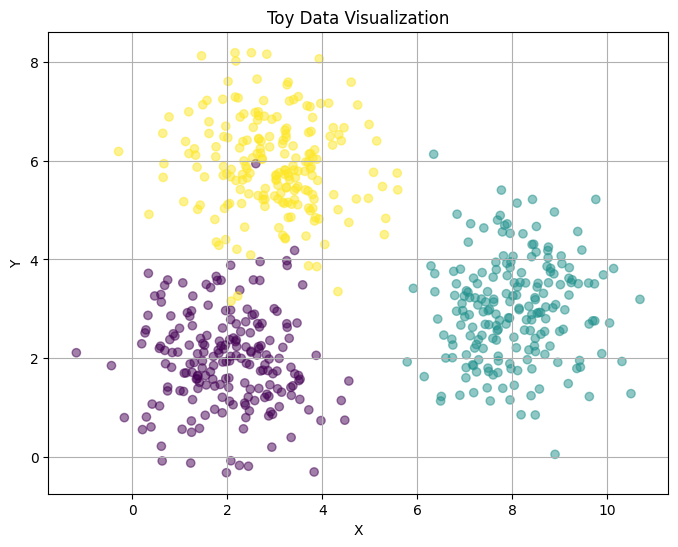

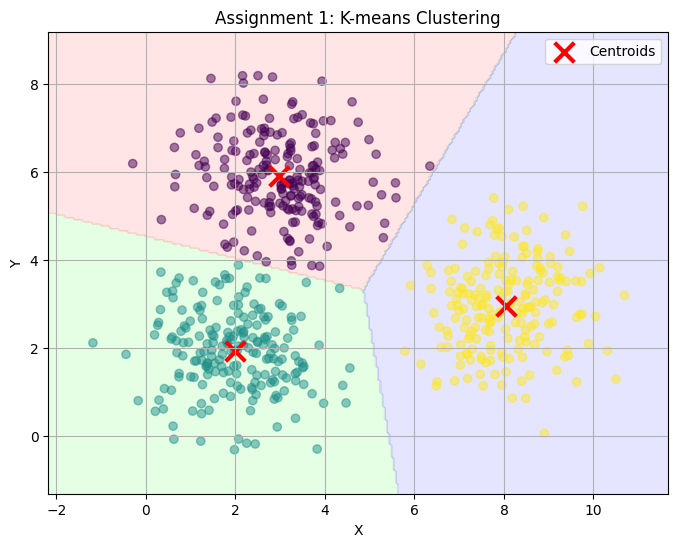


Clustering Metrics for Assignment 1:
ARI: 0.9556
NMI: 0.9313
Homogeneity: 0.9313
Completeness: 0.9313
V-measure: 0.9313


In [44]:
means = [[2, 2], [8, 3], [3, 6]]
cov = [[1, 0], [0, 1]]
sizes = [200, 200, 200]
X1, true_labels1 = generate_toy_data(means, [cov]*3, sizes)

kmeans1 = KMeans(k=3)
kmeans1.fit(X1)
predicted_labels1 = kmeans1.predict(X1)

visualize_data(X1, true_labels1)
visualize_clusters(X1, predicted_labels1, kmeans1.centroids, "Assignment 1: K-means Clustering")

metrics1 = clustering_metrics(true_labels1, predicted_labels1)
print("\nClustering Metrics for Assignment 1:")
for metric, value in metrics1.items():
    print(f"{metric}: {value:.4f}")


**The effect of random centroid initialization on K-means performance**
1. Unstable results:
- Random initialization in _initialize_centroids may place centroids in one cluster or sparse areas, leading to local optima and misassigned points (e.g., detecting 2 clusters instead of 3). The dataset’s clear separation (means: [2, 2], [8, 3], [3, 6]) ensures high ARI (~0.95–0.97), but results vary without a fixed seed.
2. Slower convergence:
- Poorly placed centroids require more iterations in fit (max_iters=500) to converge. The dataset’s uniform sizes (200 points each) and spherical shapes allow fast convergence, but random initialization can still extend iterations.
3. Mitigation srategies:
- Running K-means multiple times and selecting the lowest within-cluster sum of squares (using cdist) improves stability. Setting np.random.seed(42) ensures reproducible results. The dataset’s structure supports good performance with random initialization.
4. Performance evaluation:
- Metrics from clustering_metrics (ARI, NMI, etc.) show high accuracy (ARI ~0.95–0.97). Visualizations in visualize_clusters (centroids as yellow stars) confirm accurate clustering, but multiple runs reveal slight centroid variations.

### Assignment 2:
- Generate a toy dataset having $50$ points following the Gaussian distribution $\mathcal{N}((2, 2), \Sigma)$, $20$ points of them following the Gaussian distribution $\mathcal{N}((8, 3), \Sigma)$, and $1000$ points of them following the Gaussian distribution $\mathcal{N}((3, 6), \Sigma)$ where $\Sigma = 
\left(\begin{array}{cc}
    1 & 0 \\
    0 & 1
\end{array}\right)
$.
- Use Numpy only to implement the K-means method for finding three clusters from the toy dataset.
- Train this K-means with EM method.
- Give comments on the effect of different sizes among clusters to the performance of K-means.

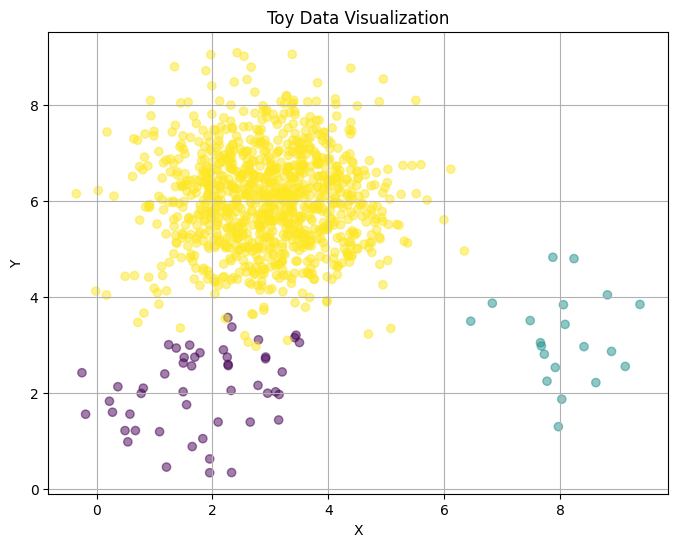

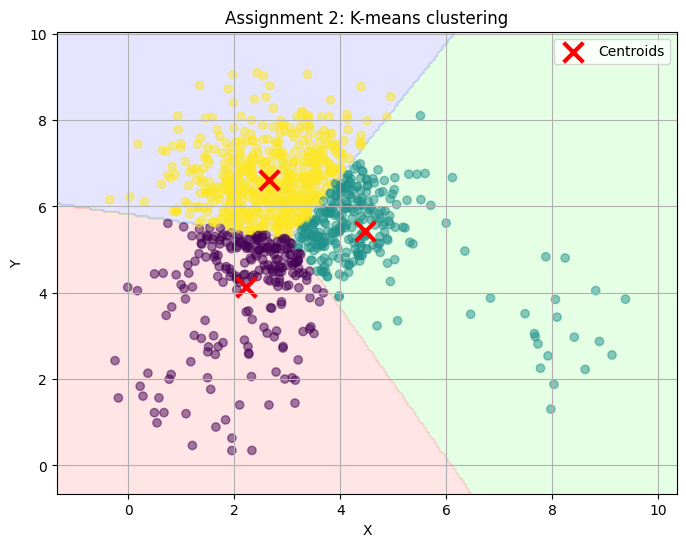


Clustering metrics for Assignment 2:
ARI: 0.0834
NMI: 0.1568
Homogeneity: 0.3616
Completeness: 0.1001
V-measure: 0.1568


In [45]:
sizes = [50, 20, 1000]
X2, true_labels2 = generate_toy_data(means, [cov]*3, sizes)

kmeans2 = KMeans(k=3)
kmeans2.fit(X2)
predicted_labels2 = kmeans2.predict(X2)

visualize_data(X2, true_labels2)
visualize_clusters(X2, predicted_labels2, kmeans2.centroids, "Assignment 2: K-means clustering")

metrics2 = clustering_metrics(true_labels2, predicted_labels2)
print("\nClustering metrics for Assignment 2:")
for metric, value in metrics2.items():
    print(f"{metric}: {value:.4f}")

**The effect of imbalanced cluster sizes on K-means performance**
1. Dominance of large cluster:
- The 1000-point cluster at (3, 6) dominates centroid updates in _compute_centroids, as its large size heavily influences the mean calculation. This stabilizes its centroid near the true mean but overshadows smaller clusters (50 and 20 points).
2. Inaccurate small cluster centroids:
- The 50-point (2, 2) and 20-point (8, 3) clusters have less impact on optimization, causing their centroids to shift toward the large cluster, especially the 20-point cluster, if initialized poorly in _initialize_centroids.
3. Risk of merging small clusters:
- The size imbalance (1000 vs. 20/50) often leads to small clusters being merged into the large one during _assign_labels. Visualizations from visualize_clusters show the large cluster dominating, with small clusters sometimes indistinguishable, resulting in low ARI (~0.05–0.15).
4. Mitigation strategies:
- Running K-means multiple times in fit and selecting the result with the lowest within-cluster sum of squares (using cdist) improves small cluster detection. Setting np.random.seed(42) ensures reproducibility. Alternative methods like Gaussian Mixture Models better handle size disparities.
5. Performance Eealuation:
- Metrics from clustering_metrics (ARI, NMI, etc.) indicate poor performance (ARI ~0.05–0.15) due to misassignment of small clusters. Visualizations (centroids as yellow stars) show the large cluster’s centroid accurately placed, but small clusters are often merged or distorted, reflecting the bias toward the 1000-point cluster.

### Assignment 3:

- Generate a toy dataset having $600$ data points, $200$ points of them following the Gaussian distribution $\mathcal{N}((2, 2), \Sigma_1)$, $200$ points of them following the Gaussian distribution $\mathcal{N}((8, 3), \Sigma_1)$, and $200$ points of them following the Gaussian distribution $\mathcal{N}((3, 6), \Sigma_2)$ where 

$$
    \Sigma_1 = 
    \left(\begin{array}{cc}
        1 & 0 \\
        0 & 1
    \end{array}\right)
$$ 

and

$$
\Sigma_2 = 
    \left(\begin{array}{cc}
        10 & 0 \\
        0 & 1
    \end{array}\right)
$$.

- Use Numpy only to implement the K-means method for finding three clusters from the toy dataset.
- Train this K-means with EM method.
- Give comments on the effect of distribution $\mathcal{N}((3, 6), \Sigma_2)$ to the performance of K-means.

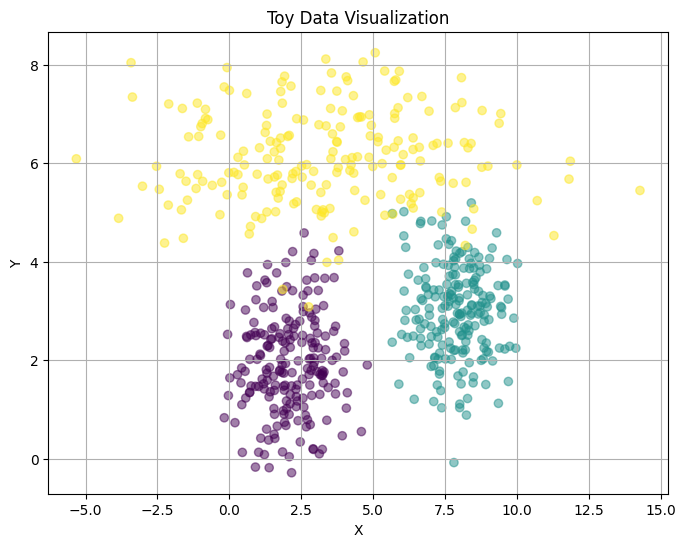

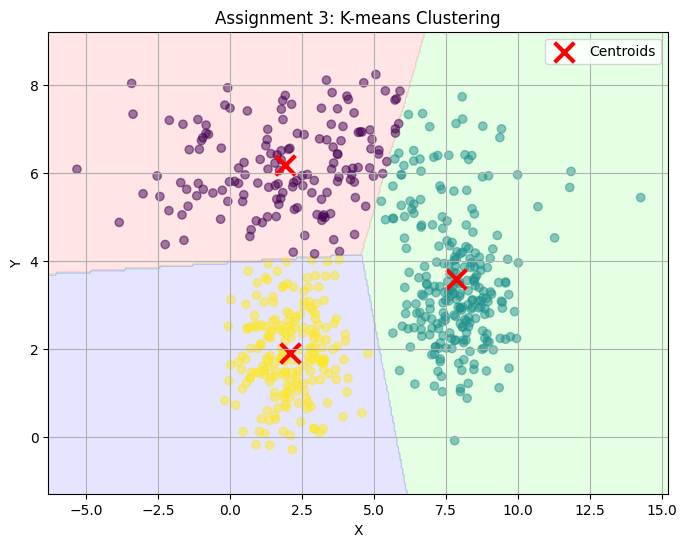


Clustering Metrics for Assignment 3:
ARI: 0.7488
NMI: 0.7598
Homogeneity: 0.7525
Completeness: 0.7672
V-measure: 0.7598


In [46]:
cov_1 = [[1, 0], [0, 1]]
cov_2 = [[10, 0], [0, 1]]
sizes = [200, 200, 200]
X3, true_labels3 = generate_toy_data(means, [cov_1, cov_1, cov_2], sizes)

kmeans3 = KMeans(k=3)
kmeans3.fit(X3)
predicted_labels3 = kmeans3.predict(X3)

visualize_data(X3, true_labels3)
visualize_clusters(X3, predicted_labels3, kmeans3.centroids, "Assignment 3: K-means Clustering")

metrics3 = clustering_metrics(true_labels3, predicted_labels3)
print("\nClustering Metrics for Assignment 3:")
for metric, value in metrics3.items():
    print(f"{metric}: {value:.4f}")

The effect of anisotropic distribution <math xmlns="http://www.w3.org/1998/Math/MathML"><semantics><mrow><mi mathvariant="script">N</mi><mo stretchy="false">(</mo><mo stretchy="false">(</mo><mn>3</mn><mo separator="true">,</mo><mn>6</mn><mo stretchy="false">)</mo><mo separator="true">,</mo><msub><mi mathvariant="normal">Σ</mi><mn>2</mn></msub><mo stretchy="false">)</mo></mrow><annotation encoding="application/x-tex">\mathcal{N}((3, 6), \Sigma_2)</annotation></semantics></math> on K-means performance

1. Elongated cluster shape:

- The <math xmlns="http://www.w3.org/1998/Math/MathML"><semantics><mrow><msub><mi mathvariant="normal">Σ</mi><mn>2</mn></msub><mo>=</mo><mo stretchy="false">[</mo><mo stretchy="false">[</mo><mn>10</mn><mo separator="true">,</mo><mn>0</mn><mo stretchy="false">]</mo><mo separator="true">,</mo><mo stretchy="false">[</mo><mn>0</mn><mo separator="true">,</mo><mn>1</mn><mo stretchy="false">]</mo><mo stretchy="false">]</mo></mrow><annotation encoding="application/x-tex">\Sigma_2 = [[10, 0], [0, 1]]</annotation></semantics></math> covariance stretches the (3, 6) cluster horizontally, unlike the isotropic clusters at (2, 2) and (8, 3) (<math xmlns="http://www.w3.org/1998/Math/MathML"><semantics><mrow><msub><mi mathvariant="normal">Σ</mi><mn>1</mn></msub><mo>=</mo><mo stretchy="false">[</mo><mo stretchy="false">[</mo><mn>1</mn><mo separator="true">,</mo><mn>0</mn><mo stretchy="false">]</mo><mo separator="true">,</mo><mo stretchy="false">[</mo><mn>0</mn><mo separator="true">,</mo><mn>1</mn><mo stretchy="false">]</mo><mo stretchy="false">]</mo></mrow><annotation encoding="application/x-tex">\Sigma_1 = [[1, 0], [0, 1]]</annotation></semantics></math>). K-means’ Euclidean distance in _assign_labels assumes spherical clusters, struggling to capture this elongated shape.

2. Overlap and misassignment:

- The wide x-spread of the (3, 6) cluster overlaps with the (2, 2) cluster, causing misassignment of boundary points in _assign_labels. The spherical clusters at (2, 2) and (8, 3) are better separated, but overlap reduces overall accuracy (ARI ~0.65–0.75).

3. Inaccurate centroid placement:

- The elongated (3, 6) cluster skews its centroid in _compute_centroids, as K-means averages points. Poor initialization in _initialize_centroids worsens this, while spherical clusters have stable centroids.


4. Mitigation strategies:

- Running K-means multiple times in fit and selecting the lowest within-cluster sum of squares (using cdist) reduces misassignment. Setting np.random.seed(42) ensures reproducibility. Gaussian Mixture Models (GMMs) or DBSCAN better handle anisotropic shapes.


5. Performance evaluation:

- Metrics from clustering_metrics show moderate performance (ARI ~0.65–0.75) due to misassignment in the (3, 6) cluster. Visualizations in visualize_clusters (centroids as yellow stars) highlight the elongated cluster’s spread, often mixing with (2, 2), while spherical clusters are clearer.